In [29]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import cv2 as cv
import cv2
from natsort import natsorted
from skimage.registration import phase_cross_correlation
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage.transform import warp
from scipy import ndimage as scp
from tqdm import tqdm
%matplotlib inline
from statsmodels.tsa.stattools import acf
import numpy as np
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric
import dipy.align.imwarp as imwarp
from dipy.data import get_fnames
from dipy.io.image import load_nifti_data
from dipy.segment.mask import median_otsu
from dipy.viz import regtools
import nibabel as nib
 
# path = 'Oct_10_2023_IR_card_motion/scan 5/pic/Flat'

# ALIGN AND FLATTEN

In [93]:
def match_image(img1,img2):
    # highlight1 = np.argmax(np.sum(img1[:500],axis=1))
    # highlight2 = np.argmax(np.sum(img2[:500],axis=1))
    # main_highlight = max(highlight1,highlight2)
    # g1 = img1[:main_highlight+50].copy()
    # g2 = img2[:main_highlight+50].copy()
    # image1 = cv.convertScaleAbs(g1)
    # image2 = cv.convertScaleAbs(g2)
    # # image1 = img1
    # # image2 = img2
    # orb = cv.ORB_create()
    # # print(img1.dtype)
    # kp1, des1 = orb.detectAndCompute(image1, None)
    # kp2, des2 = orb.detectAndCompute(image2, None)
    
    
    # bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    # matches = bf.match(des1, des2)
    # matches = sorted(matches, key=lambda x: x.distance)
    # matches = matches[:20]
    # # print(len(matches))
    # # img_matches = cv.drawMatches(image1, kp1, image2, kp2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # # plt.imshow(img_matches)
    # src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    # dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # M, _ = cv.estimateAffinePartial2D(src_pts, dst_pts)
    # M_inv = cv.invertAffineTransform(M)
    # aligned_image2 = cv.warpAffine(img2, M_inv, (img1.shape[1], img1.shape[0]))
    warped_image = phase_cross_correlation(img1[300:800], img2[300:800])
    a = np.roll(img2,shift = (int(warped_image[0][0])),axis = (0))
    return a


def parse_image(pic1,pic2,filename,path):
    if pic1.endswith('.dcm') or pic1.endswith('.DCM'):
        ds1 = dicom.dcmread(pic1)
        ds2 = dicom.dcmread(pic2,force=True)
        # pic1_flat_array = flat_image(ds1.pixel_array)
        # pic2_flat_array = flat_image(ds2.pixel_array)
    elif pic1.endswith('.png') or pic1.endswith('.PNG'):
        pass
        # pic1_flat_array = flat_image(cv.imread(pic1, cv.IMREAD_UNCHANGED))
        # pic2_flat_array = flat_image(cv.imread(pic2, cv.IMREAD_UNCHANGED))
    # pic1_flat_array = flat_image(pic1)
    # pic2_flat_array = flat_image(pic2)
    pic1_flat_array = ds1.pixel_array
    pic2_flat_array = ds2.pixel_array

    transformed_image = match_image(pic1_flat_array,pic2_flat_array)
    cv.imwrite(path + 'flat_transformed_intensity_new/' + f'{filename}' + '.PNG', transformed_image)


def flat_image(imggg):
    highlight = np.argmax(np.sum(imggg[:500],axis=1))
    tp_img = imggg[highlight-100:highlight+100].copy()
    tp_img = cv.convertScaleAbs(tp_img)

    if np.max(imggg)>500:
        _, binary_image = cv.threshold(tp_img, 100, 255,  cv.THRESH_BINARY )
    else:
        _, binary_image = cv.threshold(tp_img, 100, 255,  cv.THRESH_OTSU )
        
    for i in range(binary_image.shape[1]):
        if len(np.where(binary_image[:,i]==255)[0])!=0:
            start = min(np.where(binary_image[:,i]==255)[0])


    for i in range(binary_image.shape[1]):
        column_to_shift = i
        try:
            shift_amount = -(start - min(np.where(binary_image[:, i] == 255)[0]))
        except:
            shift_amount = 0
        num_rows = imggg.shape[0]
        new_column_index = np.arange(num_rows) + shift_amount
        new_column_index[new_column_index < 0] = 0
        new_column_index[new_column_index >= num_rows] = 0
        imggg[:, column_to_shift] = imggg[new_column_index.astype(int), column_to_shift]
    return imggg

def adj_intensity(path):
    pic_paths = os.listdir(path)
    pic_paths = natsorted(pic_paths)[:1000]
    for i in pic_paths:
        if i.endswith('.PNG'):
            all_imgs = [cv.imread(os.path.join(path, i), cv.IMREAD_UNCHANGED) for i in pic_paths if i.endswith('.PNG')]
            break
        if i.endswith('.dcm'):
            all_imgs = [dicom.dcmread(os.path.join(path, i)).pixel_array for i in pic_paths if i.endswith('.dcm')]
            break
    # all_imgs = [cv2.imread(os.path.join(path, i), cv2.IMREAD_UNCHANGED) for i in os.listdir(path)]
    # highlight = np.argmax(np.sum(g[:500],axis=1))
    average_intensities = [np.mean(g[np.argmax(np.sum(g[:500],axis=1))-100:np.argmax(np.sum(g[:500],axis=1))+100]) for g in all_imgs]
    overall_average_intensity = np.mean(average_intensities)
    intensity_img = []
    for i,j in enumerate(all_imgs):
        scale_factor =  overall_average_intensity/average_intensities[i]
        intensity_img.append((j*scale_factor).astype(np.uint16))
    return intensity_img

In [94]:
path = '2D/2D_timelapse_postsolution/scan1/pic/'

reference_img = '2D/2D_timelapse_postsolution/scan1/pic/frame1.dcm'
try:
    os.mkdir(path+'flat_transformed_intensity_new')
except:
    pass
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = natsorted(pic_paths)[:1000]

image_adjusted_intensity = adj_intensity(path)
for i,j in enumerate(image_adjusted_intensity):
    filename = pic_paths[i].removesuffix('.dcm')
    # flattened = flat_image(j)
    pic1 = reference_img
    pic2 = path+pic_paths[i]
    # try:
        # cv.imwrite(path + 'flat_transformed_intensity_new/' + f'{filename}' + '.PNG', flattened)
    parse_image(pic1,pic2,filename,path)
    # except:
    #     print(i)

# for i in pic_paths:
#     if i.endswith('.PNG'):
#         filename = i.removesuffix('.PNG')
#         pic1 = reference_img
#         pic2 = path+i
#         try:
#             parse_image(pic1,pic2,filename,path)
#         except:
#             print(i)
#     elif i.endswith('.dcm'):
#         filename = i.removesuffix('.dcm')
#         pic1 = reference_img
#         pic2 = path+i
#         try:
#             parse_image(pic1,pic2,filename,path)
#         except:
#             print(i)

# Random

In [415]:
path = '2D/2D_timelapse_postsolution/scan1/pic/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = natsorted(pic_paths)[:1000]

In [416]:
pics_without_line = []
pics_with_line = []

for i in tqdm(pic_paths):
    aa = dicom.dcmread(path+i).pixel_array
    pics_with_line.append(aa.copy())
    point = np.argmax(np.sum(aa[:500],axis=1))
    aa[point-30:point+50]=aa[0:80]
    aa[800:]=5
    pics_without_line.append(aa.copy())


100%|██████████| 1000/1000 [00:03<00:00, 330.24it/s]


In [417]:
import pickle
with open('data_pics_sc1.pickle', 'wb') as handle:
    pickle.dump(pics_without_line, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
tester = pics_without_line[900].copy()
# tester = scp.gaussian_filter(tester,sigma=3)
# tester = scp.grey_dilation(tester,size =  5)


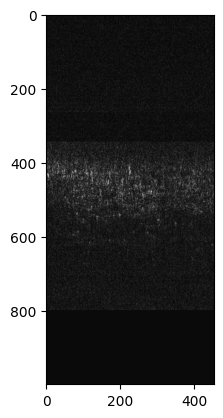

In [400]:
plt.imshow(pics_without_line[70],cmap='gray')

In [401]:
mm = []
for i in range(len(pics_without_line)):
    mm.append(np.mean(pics_without_line[i]))


In [429]:
np.correlate(pics_without_line[398][407,95].flatten(),pics_without_line[400][402,95].flatten(),mode='valid')

array([6188], dtype=uint16)

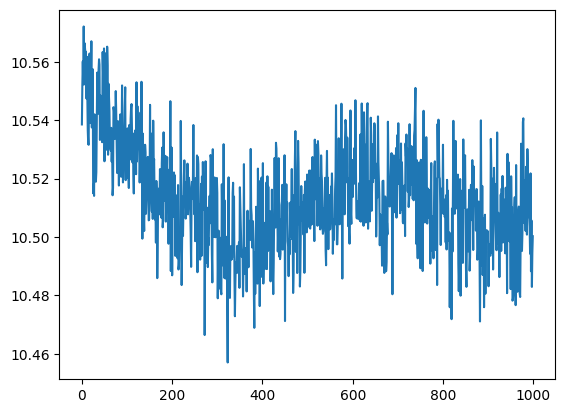

In [402]:
plt.plot(mm)

In [361]:
gg = scp.sobel(scp.minimum_filter(tester,size=15),axis=0)
mm = np.mean(scp.sobel(scp.minimum_filter(tester,size=15),axis=0))
gg = scp.binary_erosion(np.where(gg>mm,1,0),structure=np.ones((3,3)))

In [212]:
from skimage.filters import try_all_threshold,difference_of_gaussians,threshold_isodata

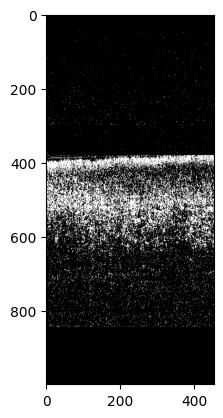

In [390]:
plt.imshow(np.where(tester>threshold_isodata(tester),1,0),cmap='gray')

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from dipy.denoise.nlmeans import nlmeans
# from dipy.denoise.noise_estimate import estimate_sigma
from dipy.data import get_fnames
from dipy.io.image import load_nifti, save_nifti
from scipy import stats
from PIL import Image
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise
from skimage.filters import gaussian


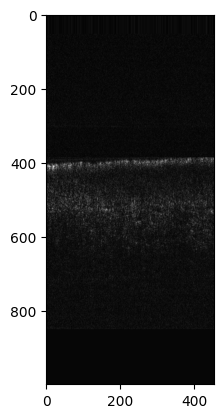

In [27]:
plt.imshow(tester,cmap='gray')

In [52]:
tester = pics_without_line[0].copy()

In [53]:
sigma = np.mean(estimate_sigma(tester))


In [65]:
patch_kw = dict(patch_size=3,      # 5x5 patches
                patch_distance=15  # 13x13 search area
                )


denoised_nlm = denoise_nl_means(tester, h=0.9 * sigma, fast_mode=True,
                                **patch_kw)

In [99]:
static = pics_without_line[0]
moving = pics_without_line[900]

In [16]:
def callback_CC(sdr, status):
    # Status indicates at which stage of the optimization we currently are
    # For now, we will only react at the end of each resolution of the scale
    # space
    if status == imwarp.RegistrationStages.SCALE_END:
        # get the current images from the metric
        wmoving = sdr.metric.moving_image
        wstatic = sdr.metric.static_image
        # draw the images on top of each other with different colors
        regtools.overlay_images(wmoving, wstatic, 'Warped moving', 'Overlay',
                                'Warped static')

In [101]:
sigma_diff = 3.0
radius = 4
metric = CCMetric(2, sigma_diff, radius)
level_iters = [100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)
sdr.callback = callback_CC

In [ ]:
mapping = sdr.optimize(static, moving)
warped = mapping.transform(moving);

In [17]:
def dipy_register(static, moving):
    sigma_diff = 3.0
    radius = 4
    metric = CCMetric(2, sigma_diff, radius)
    level_iters = [100, 50, 25]
    sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)
    sdr.callback = callback_CC
    mapping = sdr.optimize(static, moving)
    warped = mapping.transform(moving);
    return warped;

In [ ]:
stat = pics_without_line[500]
registered = []
for i in range(0,len(pics_without_line),20):
    registered.append(dipy_register(stat,pics_without_line[i]));

50

In [166]:
from os.path import join as pjoin
import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi
from dipy.data.fetcher import fetch_syn_data
from dipy.io.image import load_nifti
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform2D,
                                   RigidTransform2D,
                                   AffineTransform2D)
from dipy.align import affine_registration, register_dwi_to_template


In [104]:
static = pics_without_line[500]
static_grid2world = np.eye(4)

moving = pics_without_line[900]
moving_grid2world = np.eye(4)

In [254]:
import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi
from dipy.data.fetcher import fetch_syn_data
from dipy.io.image import load_nifti
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform2D,
                                   RigidTransform2D,
                                   AffineTransform2D)
from dipy.align import affine_registration, register_dwi_to_template
from dipy.align.transforms import AffineTransform2D
from dipy.align.imaffine import AffineRegistration
from matplotlib.colors import hsv_to_rgb

In [252]:
affreg = AffineRegistration(verbosity=0)
transform = AffineTransform2D()

def aff_reg(static,moving):
    affine = affreg.optimize(static, moving, transform, params0=None);
    regss = affine.transform(moving);
    return regss;

In [253]:
stat = pics_without_line[500]
registered_aff = []
for i in tqdm(range(0,len(pics_without_line),20),leave=False):
    registered_aff.append(aff_reg(stat,pics_without_line[i]));

In [167]:
registered_aff_arr = np.array(registered_aff)

In [168]:
# registered_aff_arr = np.expand_dims(registered_aff_arr, axis=3)

In [184]:
# sigma = estimate_sigma(registered_aff_arr, N=32)
# mask = registered_aff_arr > 20
# den = nlmeans(registered_aff_arr, sigma=sigma, mask=mask, patch_radius=1,
#               block_radius=2, rician=True)


In [404]:
mm=[]
for i in range(len(registered_aff)):
    mm.append(np.mean(registered_aff[i][481:485,159:163]))

In [405]:
import scipy.fftpack

<StemContainer object of 3 artists>

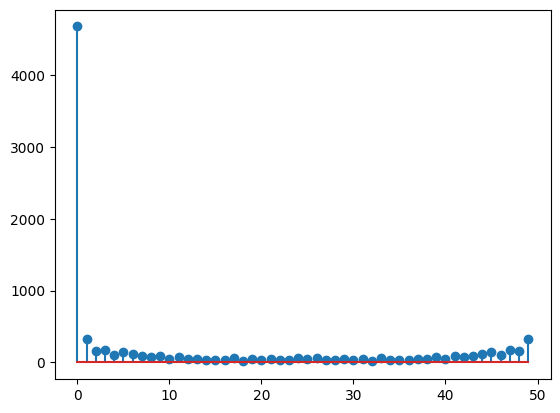

In [411]:
plt.stem(np.abs((scipy.fftpack.fft(mm))))

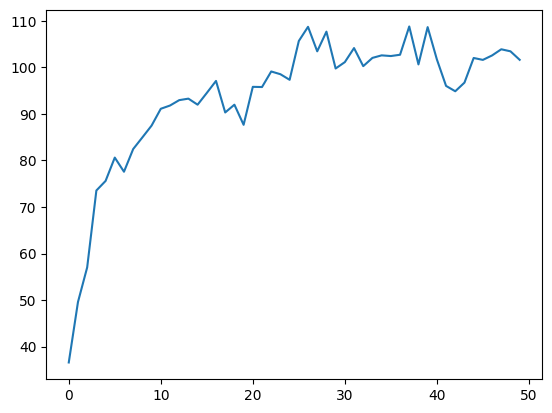

In [393]:
plt.plot(mm)

# align using phase

In [385]:
# def apply_tranforms(tester):
#     tester = scp.gaussian_filter(tester,sigma=3)
#     gg = scp.sobel(scp.minimum_filter(tester,size=15),axis=0)
#     mm = np.mean(scp.sobel(scp.minimum_filter(tester,size=15),axis=0))
#     gg = scp.binary_erosion(np.where(gg>mm,1,0),structure=np.ones((3,3)))
#     return gg


In [13]:
rand_range = [500,910]
# trans_pic10 = apply_tranforms(pics_without_line[10])
for _ in rand_range:
    for i in tqdm(range(len(pics_without_line))):
        coords = phase_cross_correlation(pics_without_line[_],pics_without_line[i],normalization=None)[0]
        pics_without_line[i] = scp.shift(pics_without_line[i],shift = (int(coords[0]),int(coords[1])),mode='nearest',order=0)
        pics_with_line[i] = scp.shift(pics_with_line[i],shift = (int(coords[0]),int(coords[1])),mode='nearest',order = 0)



100%|██████████| 1000/1000 [00:56<00:00, 17.77it/s]


In [221]:
# os.mkdir(path+'aligned/a_registered_aff')
for i,j in tqdm(enumerate(registered_aff)):
    # if i%2==0:
    cv.imwrite(path+'aligned/a_registered_aff/'+f'frame{i}.PNG',j.astype(np.uint16))

50it [00:00, 166.77it/s]


In [226]:
def liv_calc(pp):
    return(10*(np.log10(pp+1)))
log_pics = list(map(liv_calc,registered_aff))
arrays_np = np.array(log_pics)
average_across_arrays = np.mean(arrays_np, axis=0)

liv_mask = np.zeros_like(average_across_arrays)
for j in tqdm(range(len(log_pics))):
    liv_mask += (log_pics[j] - average_across_arrays)**2
liv_mask/=len(log_pics)


100%|██████████| 50/50 [00:00<00:00, 1760.01it/s]


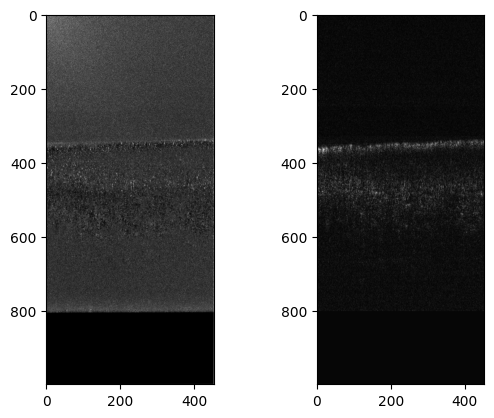

In [228]:
plt.subplot(1,2,1)
plt.imshow(liv_mask,cmap='gray')

plt.subplot(1,2,2)
plt.imshow(pics_without_line[700],cmap='gray')

In [389]:
h = liv_mask
s = np.full_like(liv_mask,1)
v = registered_aff[49]
# v = MinMaxScaler().fit_transform(v)
# v_ =v/np.iinfo(v.dtype).max
# h /=np.max(h)
hsv_liv = np.transpose([h, s, v], (1, 2, 0))
rgb_liv = hsv_to_rgb(hsv_liv)
# rgb_ocds = rgb_ocds[:,:,::-1]

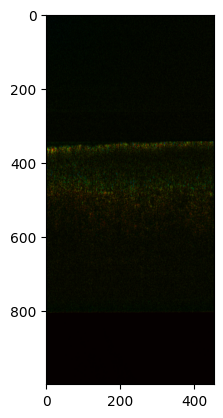

In [390]:
plt.imshow(rgb_liv.astype(np.uint8))
plt.imsave('ooo.png',rgb_liv.astype(np.uint8))

In [1289]:
h = np.where(liv_mask>3,0.4,0).astype(np.float32)
# h = np.zeros_like(mask_ocds[...,1]).astype(np.uint8)
s = np.full_like(liv_mask,1).astype(np.float32)
v = pics_without_line[120].astype(np.float32)
# h = MinMaxScaler().fit_transform(h)
# v = MinMaxScaler().fit_transform(v).astype(np.float32)
# v_ = v/255
hsv_ocds = np.transpose([h, s, v], (1, 2, 0))
rgb_ocds = hsv_to_rgb(hsv_ocds)

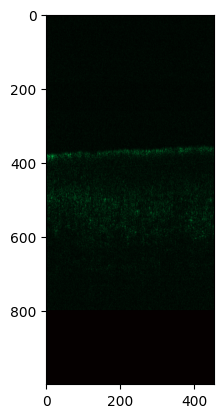

In [1291]:
plt.imshow((rgb_ocds).astype(np.uint8))

In [1285]:
# # os.mkdir(path+'aligned/intensity_adj/')
# for i in tqdm(range(len(pics_without_line))):
#     k = cv.addWeighted(pics_with_line[i], 1, (liv_mask).astype(np.uint16), 1, 0.0)
#     cv.imwrite(path+'aligned/intensity_adj/'+f'frame{i}.PNG',k)

In [266]:
ocds_array = np.array(log_pics)

In [ ]:
# corrs = []
# slope, intercept = np.polyfit(range(len(corrs)),np.array(corrs),deg=1)
# for i in range(2,len(pics_with_line),2):    
#     corrs.append(np.corrcoef(np.log10(pics_without_line[0][:,161]+1),np.log10(pics_without_line[i][:,161]+1))[0][1])

In [16]:
# time_lags = np.arange(0, 1000,2)

In [267]:
from scipy.signal import correlate as sc

In [268]:
from statsmodels.tsa.stattools import acf as acf_calc

In [273]:
ocds_array[0].shape

(1000, 454)

In [275]:
mask_ocds = np.zeros((ocds_array.shape[1],ocds_array.shape[2],2))
for i in tqdm(range(ocds_array[0].shape[0])):
    for j in (range(ocds_array[0].shape[1])):
        range_tou_e = list(range(0,20,2))
        range_tou_l = list(range(20,50,2))
        cofs_e = acf_calc(ocds_array[:,i,j],nlags=50)[range_tou_e]
        cofs_l = acf_calc(ocds_array[:,i,j],nlags=50)[range_tou_l]
        slope_e = -np.polyfit(range_tou_e, cofs_e, 1)[0]
        slope_l = -np.polyfit(range_tou_l, cofs_l, 1)[0]
        if np.isnan(slope_e):
            mask_ocds[i,j,0]=0
        else:
            if slope_e>0:
                mask_ocds[i,j,0] = slope_e
            else:
                mask_ocds[i,j,0] = -slope_e
        if np.isnan(slope_l):
            mask_ocds[i,j,1]=0
        else:
            if slope_l>0:
                mask_ocds[i,j,1] = slope_l
            else:
                mask_ocds[i,j,1] = -slope_l

100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]


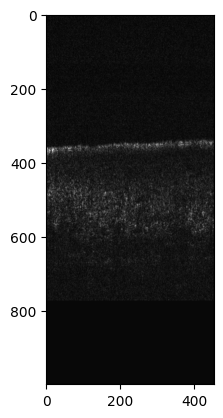

In [276]:
plt.imshow(registered_aff[3],cmap='gray',interpolation=None)

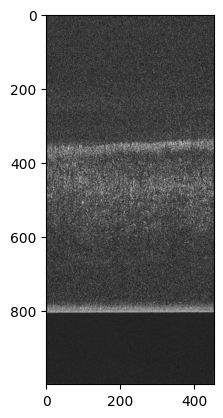

In [280]:
plt.imshow((mask_ocds[...,0]*255).astype(np.uint16),cmap='gray')

In [282]:
cofs = acf_calc(ocds_array[:,407,67],nlags=1000)

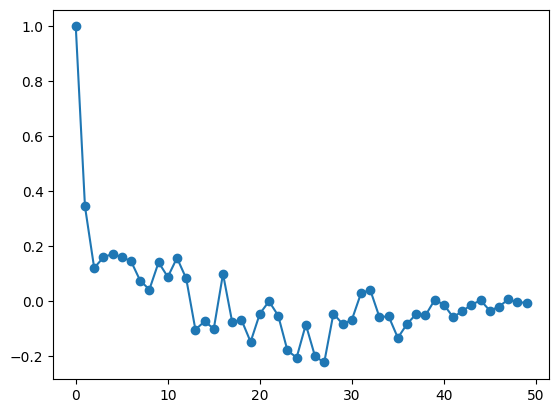

In [283]:
plt.plot(cofs,marker='o')

In [827]:
-np.polyfit(np.divide(list(range(300,700,2)),498),cofs, 1)[0]

0.2555368704838646

# Trial

In [450]:
oct_signal = ocds_array[:,67,67]
oct_signal_tou = ocds_array[[k for k in range(0,1000,1)],67,67]
# time_lags = np.arange(0,400,2) 
# acf_corrs = np.correlate(oct_signal, oct_signal_tou, mode='full')
# acf_corrs = acf_corrs[len(acf_corrs)//2:]

In [451]:
sc(ocds_array[0,67,67], ocds_array[2,67,67], mode='full',method='fft')

50.87997186422614

In [452]:
acf_calc(oct_signal,nlags=6)

array([ 1.        , -0.00313117,  0.00716389, -0.01403186, -0.00740999,
       -0.00357893,  0.31071284])

In [453]:
temp = []
lags = range(700,1000,2)
for i in lags:
    start = 0
    lag = i
    end = i + start
    cov_k = np.cov(ocds_array[start:end,67,407], ocds_array[end-lag:end,67,407])[0, 1]
    var1 = np.var(ocds_array[start:end,67,407])
    var2 = np.var(ocds_array[end-lag:end,67,407])
    temp.append(cov_k/(var1*var2))
slope = np.polyfit(lags, temp, 1)[0]

In [1508]:
np.polyfit(temp, lags, 1)[0]

41014.48697010515

In [1501]:
slope

2.437572878663535e-05

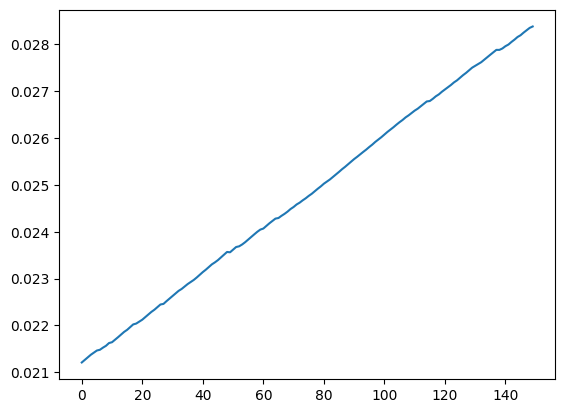

In [1502]:
plt.plot(temp)

In [1275]:
autocorr = sc(oct_signal, oct_signal_tou, mode='full',method='fft')
autocorr = autocorr[len(autocorr)//2:]
# Normalize autocorrelation values
autocorr /= np.max(autocorr)

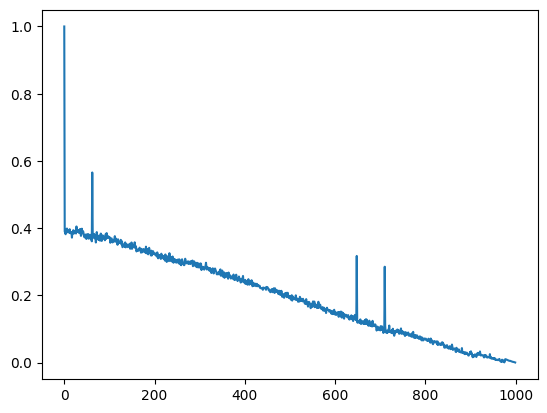

In [1276]:
plt.plot(autocorr)

In [1683]:
ocds_mask_new = np.zeros((ocds_array.shape[1],ocds_array.shape[2],2),dtype=np.uint16)
for ij in tqdm(np.ndindex(ocds_array[0].shape)):
    i,j = ij
    # print(i,j)
    oct_signal = ocds_array[:,i,j]
    time_lags = np.arange(1000) 
    acf_corrs = np.correlate(oct_signal, oct_signal, mode='full')
    acf_corrs = acf_corrs[len(acf_corrs)//2:]
    ocds_e = -np.polyfit(time_lags[:400], acf_corrs[:400], 1)[0]
    ocds_l = -np.polyfit(time_lags[-600:], acf_corrs[-600:], 1)[0]
    ocds_mask_new[i,j,0] = ocds_e
    ocds_mask_new[i,j,1] = ocds_l



0it [00:00, ?it/s]

454000it [03:07, 2419.32it/s]


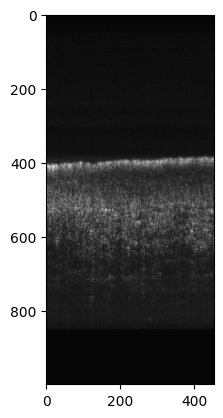

In [1853]:
plt.imshow(ocds_mask_new[...,0],interpolation=None)
plt.show()

# HSV

In [284]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import hsv_to_rgb
# os.mkdir('/Users/akapatil/Documents/OCT/2D/2D_timelapse_postsolution/scan1/pic/hsv/')

In [1045]:
for i in tqdm(range(0,1000)):
    h = np.where(mask_ocds[...,1]>2e-4,0.4,0)
    s = np.full_like(mask_ocds[...,1],1)
    v = pics_without_line[i]

    hsv_ocds = np.transpose([h, s, v], (1, 2, 0))
    rgb_ocds = hsv_to_rgb(hsv_ocds)
    rgb_ocds = rgb_ocds[:,:,::-1]
    cv2.imwrite(f'/Users/akapatil/Documents/OCT/2D/2D_timelapse_postsolution/scan1/pic/hsv/hsv_{i}.PNG',(rgb_ocds).astype(np.uint8))

100%|██████████| 1000/1000 [00:30<00:00, 32.98it/s]


In [318]:
np.sort(mask_ocds[...,0].flatten())

array([0.00879212, 0.00988943, 0.01001015, ..., 0.08082813, 0.08279653,
       0.08701474])

In [347]:
h = np.where(mask_ocds[...,1]>2e-4,0.4,0).astype(np.float32)
# h = np.zeros_like(mask_ocds[...,1]).astype(np.uint8)
s = np.full_like(mask_ocds[...,1],1).astype(np.float32)
v = registered_aff[20].astype(np.float32)
# h = MinMaxScaler().fit_transform(h)
# v = MinMaxScaler().fit_transform(v).astype(np.float32)
v_ = v/255
hsv_ocds = np.transpose([h, s, v_], (1, 2, 0))
rgb_ocds = hsv_to_rgb(hsv_ocds)
# rgb_ocds = rgb_ocds[:,:,::-1]

In [342]:
img_hsv = cv2.cvtColor(hsv_ocds, cv2.COLOR_HSV2RGB)

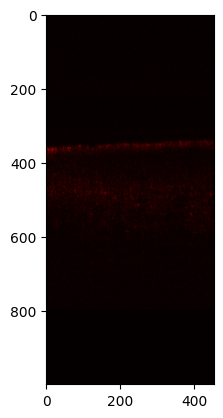

In [329]:
plt.imshow((img_hsv*255).astype(np.uint8),interpolation=None)
# plt.imsave('ooo.png',(rgb_ocds).astype(np.uint8))


In [1293]:
# OCDS_mask_e = np.ones_like(ocds_array[0])

# for i in tqdm(range(ocds_array.shape[1])):
#     for j in range(ocds_array.shape[2]):
#         temp_cov = ocds_array[[k for k in range(0,len(pics_without_line[0])-700,2)],i,j]
#         corr_vals = acf(temp_cov,nlags = len(temp_cov),fft =True)
#         slope, intercept = np.polyfit(range(len(corr_vals)),np.array(corr_vals),deg=1)
#         if not slope:
#             print(i,j)
#         OCDS_mask_e[i,j] = slope



In [1294]:
# plt.subplot(1,2,1)
# plt.imshow(OCDS_mask_e*-1,cmap='gray')

# plt.subplot(1,2,2)
# plt.imshow(pics_with_line[500],cmap='gray')

In [1295]:
# OCDS_mask_l = np.ones_like(ocds_array[0])

# for i in tqdm(range(ocds_array.shape[1])):
#     for j in range(ocds_array.shape[2]):
#         temp_cov = ocds_array[[k for k in range(600,len(pics_with_line[0]),2)],i,j]
#         # temp_cov = temp_cov[:50]
#         corr_vals = acf(temp_cov,nlags = len(temp_cov),fft =False)
#         slope, intercept = np.polyfit(range(len(corr_vals)),np.array(corr_vals),deg=1)
#         if not slope:
#             print(i,j)
#         OCDS_mask_l[i,j] = slope



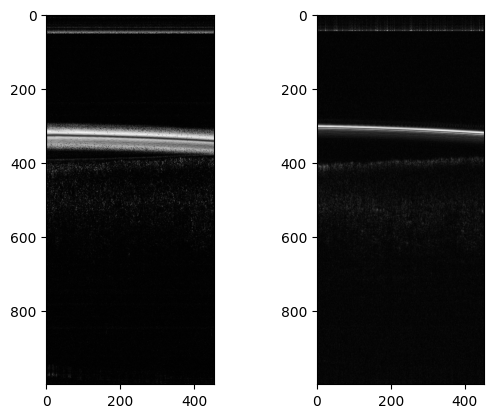

In [320]:
# plt.subplot(1,2,1)
# plt.imshow(OCDS_mask_l*-1,cmap='gray')

# plt.subplot(1,2,2)
# plt.imshow(pics_with_line[500],cmap='gray')

In [380]:
# OCDS_mask_tou = np.ones_like(ocds_array[0])

# for i in tqdm(range(ocds_array.shape[1])):
#     for j in range(ocds_array.shape[2]):
#         temp_cov = ocds_array[[k for k in range(0,len(pics_with_line[0])-700,16)],i,j]
#         # temp_cov = temp_cov[:50]
#         corr_vals = acf(temp_cov,nlags = len(temp_cov),fft =False)
#         slope, intercept = np.polyfit(range(len(corr_vals)),np.array(corr_vals),deg=1)
#         if not slope:
#             print(i,j)
#         OCDS_mask_tou[i,j] = slope



100%|██████████| 1000/1000 [00:23<00:00, 42.57it/s]


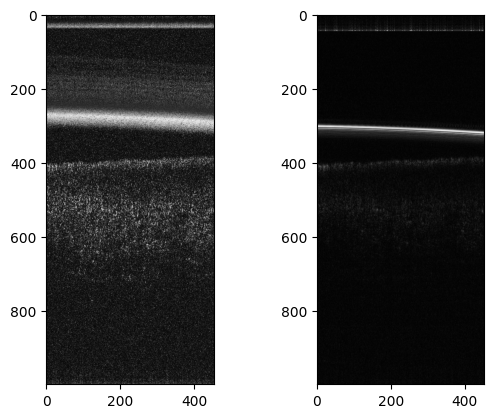

In [381]:
# plt.subplot(1,2,1)
# plt.imshow(OCDS_mask_tou*-1,cmap='gray')

# plt.subplot(1,2,2)
# plt.imshow(pics_with_line[500],cmap='gray')

In [1296]:
# temp_cov = ocds_array[[k for k in range(0,len(pics_with_line[0]),2)],10,100]
# corr_vals = acf(temp_cov,nlags = len(temp_cov),fft =False)[1:]

In [1297]:
# plt.plot(corr_vals)

In [864]:
hsv_image = np.transpose([np.full_like(pics_with_line[0],fill_value=slope), np.ones_like(pics_with_line[0]), pics_with_line[0]], (1, 2, 0))
tmp_img_hsv = cv.cvtColor(hsv_image.astype(np.float32), cv.COLOR_HSV2RGB).astype(np.uint16)

# IR-Card LIV

In [1309]:
IR_path = '/Users/akapatil/Documents/OCT/Oct_10_2023_IR_card_motion/scan 5/pic/flat_transformed_new/'
IR_pic_paths = []
for i in os.listdir(IR_path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        IR_pic_paths.append(i)
IR_pic_paths = natsorted(IR_pic_paths)

In [1310]:
IR_pics_without_line = []
IR_pics_with_line = []

# for i in tqdm(IR_pic_paths):
#     aa = dicom.dcmread(IR_path+i).pixel_array
#     IR_pics_with_line.append(aa.copy())
#     point = np.argmax(np.sum(aa[:500],axis=1))
#     aa[point-30:point+50]=aa[0:80]
#     aa[800:]=5
#     IR_pics_without_line.append(aa.copy())


for i in tqdm(IR_pic_paths):
    aa = cv.imread(IR_path+i,cv.IMREAD_UNCHANGED)
    # aa = dicom.dcmread(IR_path+i).pixel_array
    IR_pics_with_line.append(aa.copy())
    # point = np.argmax(np.sum(aa[:500],axis=1))
    # aa[point-30:point+50]=aa[0:80]
    # aa[800:]=5
    IR_pics_without_line.append(aa.copy())

100%|██████████| 1000/1000 [00:14<00:00, 70.42it/s]


In [1311]:
def liv_calc(pp):
    return(10*(np.log10(pp+1)))
IR_log_pics = list(map(liv_calc,IR_pics_with_line))
arrays_np = np.array(IR_log_pics)
average_across_arrays = np.mean(arrays_np, axis=0)

IR_liv_mask = np.zeros_like(average_across_arrays)
for j in tqdm(range(len(IR_log_pics))):
    IR_liv_mask += (IR_log_pics[j] - average_across_arrays)**2
IR_liv_mask/=len(IR_log_pics)

100%|██████████| 1000/1000 [00:00<00:00, 3473.83it/s]


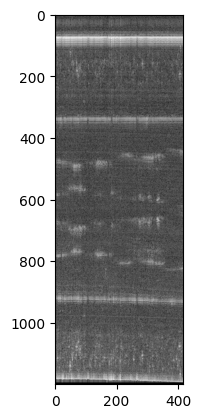

In [1312]:
plt.imshow(10*np.log10(IR_pics_without_line[76]+1),cmap='gray')

In [1259]:
np.log10(IR_pics_with_line[0]+1)

array([[0.845098  , 1.30103   , 1.        , ..., 0.845098  , 0.47712126,
        0.9542425 ],
       [1.0791812 , 1.20412   , 1.0791812 , ..., 1.        , 0.60206   ,
        0.90309   ],
       [1.1760913 , 1.146128  , 1.0413927 , ..., 1.        , 0.90309   ,
        0.60206   ],
       ...,
       [1.1760913 , 1.2552725 , 1.0791812 , ..., 1.8920946 , 2.1238515 ,
        1.6627579 ],
       [1.1760913 , 1.2552725 , 1.0791812 , ..., 1.9542425 , 1.908485  ,
        2.0253057 ],
       [1.1760913 , 1.2552725 , 1.0791812 , ..., 2.3443923 , 0.60206   ,
        2.1875207 ]], dtype=float32)

In [1260]:
IR_log_pics

[array([[ 8.45098  , 13.010301 , 10.       , ...,  8.45098  ,  4.7712126,
          9.542425 ],
        [10.791812 , 12.041201 , 10.791812 , ..., 10.       ,  6.0206003,
          9.0309   ],
        [11.760913 , 11.461281 , 10.413927 , ..., 10.       ,  9.0309   ,
          6.0206003],
        ...,
        [11.760913 , 12.552725 , 10.791812 , ..., 18.920946 , 21.238516 ,
         16.627579 ],
        [11.760913 , 12.552725 , 10.791812 , ..., 19.542425 , 19.08485  ,
         20.253057 ],
        [11.760913 , 12.552725 , 10.791812 , ..., 23.443924 ,  6.0206003,
         21.875208 ]], dtype=float32),
 array([[0.       , 0.       , 0.       , ..., 4.7712126, 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 4.7712126, 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 3.0103002, 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0

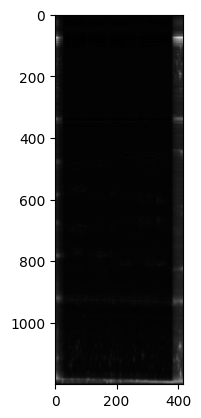

In [1313]:
plt.imshow(IR_liv_mask,cmap='gray')

In [336]:
# def liv_calc(pp):
#     return(10*(np.log10(pp+1e-16)))
# IR_log_pics = list(map(liv_calc,IR_pics_with_line))
# arrays_np = np.array(IR_log_pics)
# average_across_arrays = np.mean(arrays_np, axis=0)

# IR_liv_mask = np.zeros_like(average_across_arrays)
# for j in tqdm(range(len(IR_log_pics))):
#     IR_liv_mask += (IR_log_pics[j] - average_across_arrays)**2
# IR_liv_mask/=len(IR_log_pics)

100%|██████████| 1000/1000 [00:02<00:00, 496.49it/s]


In [ ]:
# hsv_image = np.transpose([IR_liv_mask, np.ones_like(IR_liv_mask), IR_pics_with_line[0]], (1, 2, 0))
# tmp_img_hsv = cv.cvtColor(hsv_image.astype(np.float32), cv.COLOR_HSV2RGB).astype(np.uint16)

In [ ]:
# h = IR_liv_mask.astype(np.uint16)
# s = np.ones_like(IR_liv_mask).astype(np.uint16)
# v = IR_pics_with_line[0]

In [1262]:
IR_ocds_array = np.array(IR_log_pics)

In [1]:
plt.imshow(IR_pics_with_line[900],cmap='gray')

NameError: name 'plt' is not defined

In [1264]:
IR_ocds_mask_new = np.zeros((IR_ocds_array.shape[1],IR_ocds_array.shape[2]))
for i,j in tqdm(np.ndindex(IR_ocds_array[0].shape)):
    cofs = acf_calc(IR_ocds_array[:,i,j],nlags=1000)[range(0,500,2)]
    slope = -np.polyfit(range(0,500,2), cofs, 1)[0]
    if slope<0:
        print('neg')
    if np.isnan(slope):
        IR_ocds_mask_new[i,j]=0
    else:
        IR_ocds_mask_new[i,j] = slope

0it [00:00, ?it/s]

500400it [01:31, 5474.20it/s]


In [625]:
# IR_ocds_mask_new = np.zeros((IR_ocds_array.shape[1],IR_ocds_array.shape[2],2),dtype=np.uint16)
# for ij in tqdm(np.ndindex(IR_ocds_array[0].shape)):
#     i,j = ij
#     # print(i,j)
#     oct_signal = IR_ocds_array[:,i,j]
#     time_lags = np.arange(1000) 
#     acf_corrs = np.correlate(oct_signal, oct_signal, mode='full')
#     acf_corrs = acf_corrs[len(acf_corrs)//2:]
#     ocds_e = -np.polyfit(time_lags[:400], acf_corrs[:400], 1)[0]
#     ocds_l = -np.polyfit(time_lags[-600:], acf_corrs[-600:], 1)[0]
#     IR_ocds_mask_new[i,j,0] = ocds_e
#     IR_ocds_mask_new[i,j,1] = ocds_l



500400it [03:42, 2247.89it/s]


In [981]:
2e-4

0.0002

In [982]:
np.where(IR_ocds_mask_new>2e-4,0.4,0)

array([[0. , 0. , 0.4, ..., 0.4, 0.4, 0.4],
       [0. , 0. , 0.4, ..., 0.4, 0.4, 0.4],
       [0. , 0. , 0.4, ..., 0.4, 0.4, 0.4],
       ...,
       [0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
       [0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
       [0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4]])

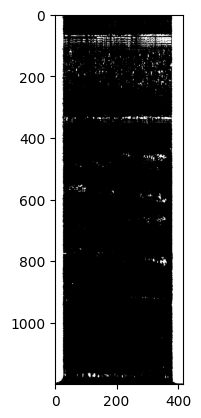

In [1265]:
plt.imshow(np.where(IR_ocds_mask_new>2e-4,0.4,0),cmap='gray')

In [1267]:
h = np.where(IR_ocds_mask_new>2e-4,0.4,0)
s = np.full_like(IR_ocds_mask_new,1)
v = IR_pics_without_line[0]
# h = MinMaxScaler((0,1)).fit_transform(h)
v = MinMaxScaler().fit_transform(v)
# v_ = v/255
hsv_ocds = np.transpose([h, s, v], (1, 2, 0))
rgb_ocds = hsv_to_rgb(hsv_ocds)
# rgb_ocds = rgb_ocds[:,:,::-1]

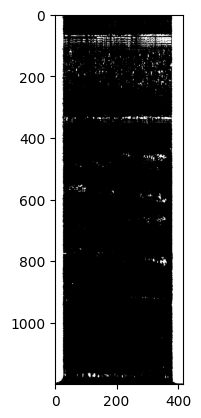

In [1268]:
plt.imshow(h,cmap='gray')

In [1269]:
rgb_ocds

array([[[0.        , 0.00941915, 0.00376766],
        [0.        , 0.03423423, 0.01369369],
        [0.        , 0.02261307, 0.00904523],
        ...,
        [0.        , 0.02281369, 0.00912548],
        [0.        , 0.00980392, 0.00392157],
        [0.        , 0.03319502, 0.01327801]],

       [[0.        , 0.01726845, 0.00690738],
        [0.        , 0.02702703, 0.01081081],
        [0.        , 0.02763819, 0.01105528],
        ...,
        [0.        , 0.03422053, 0.01368821],
        [0.        , 0.01470588, 0.00588235],
        [0.        , 0.02904564, 0.01161826]],

       [[0.        , 0.02197802, 0.00879121],
        [0.        , 0.02342342, 0.00936937],
        [0.        , 0.02512563, 0.01005025],
        ...,
        [0.        , 0.03422053, 0.01368821],
        [0.        , 0.03431373, 0.01372549],
        [0.        , 0.01244813, 0.00497925]],

       ...,

       [[0.        , 0.02197802, 0.00879121],
        [0.03063063, 0.        , 0.        ],
        [0.02763819, 0

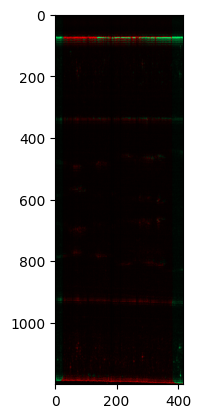

In [1270]:
plt.imshow(rgb_ocds)

In [ ]:
corrs = []
for i in range(2,len(pics_with_line),2):    
    corrs.append(np.corrcoef(np.log10(pics_without_line[0][:,161]+1),np.log10(pics_without_line[i][:,161]+1))[0][1])

In [385]:
IR_OCDS_mask_e = np.ones_like(IR_ocds_array[0])

for i in tqdm(range(IR_ocds_array.shape[1])):
    for j in range(IR_ocds_array.shape[2]):
        temp_cov = IR_ocds_array[[k for k in range(1,IR_ocds_array.shape[0],2)],i,j]
        # temp_cov = IR_ocds_array[:,i,j]
        # temp_cov = temp_cov[500:]
        corr_vals = acf(temp_cov,nlags = len(temp_cov),fft =True)
        slope, intercept = np.polyfit(range(len(corr_vals)),np.array(corr_vals),deg=1)
        if not slope:
            print(i,j)
        IR_OCDS_mask_e[i,j] = slope



100%|██████████| 1200/1200 [01:54<00:00, 10.49it/s]


In [ ]:
temp_cov = IR_ocds_array[[k for k in range(1,IR_ocds_array.shape[0],2)],i,j]
corr_vals = acf(temp_cov,nlags = len(temp_cov),fft =True)

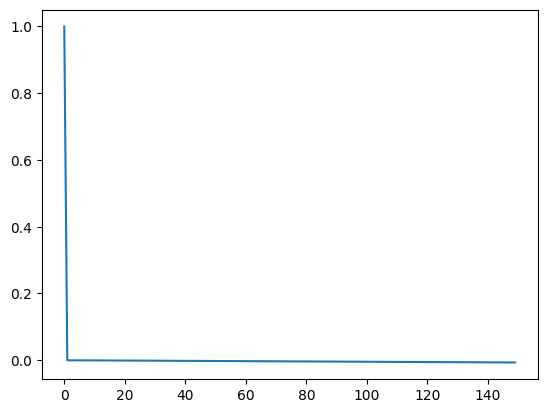

In [373]:
plt.plot(corr_vals)

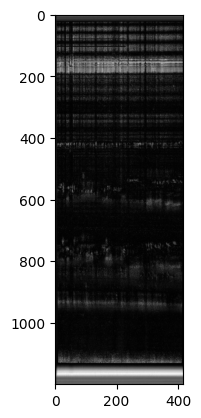

In [386]:
plt.imshow((IR_OCDS_mask_e*-1),cmap='gray')

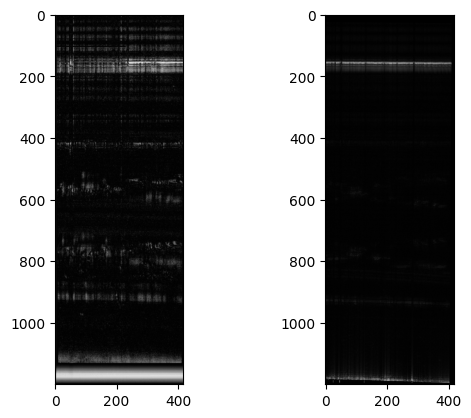

In [367]:
plt.subplot(1,2,1)
plt.imshow(IR_OCDS_mask_e*-1,cmap='gray')

plt.subplot(1,2,2)
plt.imshow(IR_pics_with_line[500],cmap='gray')

In [327]:
IR_OCDS_mask_l = np.ones_like(IR_ocds_array[0])

for i in tqdm(range(IR_ocds_array.shape[1])):
    for j in range(IR_ocds_array.shape[2]):
        temp_cov = IR_ocds_array[[k for k in range(700,IR_ocds_array.shape[0],2)],i,j]
        # temp_cov = IR_ocds_array[:,i,j]
        # temp_cov = temp_cov[500:]
        corr_vals = acf(temp_cov,nlags = len(temp_cov),fft =False)[1:]
        slope, intercept = np.polyfit(range(len(corr_vals)),np.array(corr_vals),deg=1)
        if not slope:
            print(i,j)
        IR_OCDS_mask_l[i,j] = slope



100%|██████████| 1200/1200 [00:52<00:00, 22.70it/s]


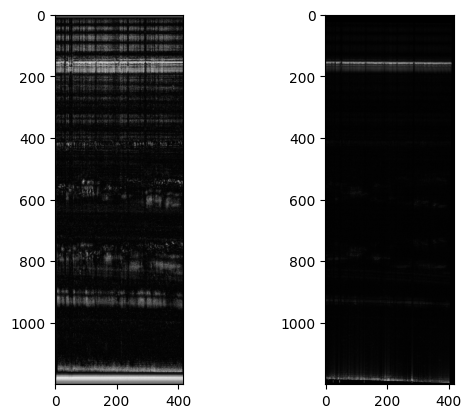

In [328]:
plt.subplot(1,2,1)
plt.imshow(IR_OCDS_mask_l*-1,cmap='gray')

plt.subplot(1,2,2)
plt.imshow(IR_pics_with_line[500],cmap='gray')

In [826]:
IR_OCDS_mask_tou = np.ones_like(IR_ocds_array[0])

for i in tqdm(range(IR_ocds_array.shape[1])):
    for j in range(IR_ocds_array.shape[2]):
        temp_cov = IR_ocds_array[[k for k in range(0,IR_ocds_array.shape[0]-700,16)],i,j]
        # temp_cov = IR_ocds_array[:,i,j]
        # temp_cov = temp_cov[500:]
        corr_vals = acf(temp_cov,nlags = len(temp_cov),fft =False)[1:]
        slope, intercept = np.polyfit(range(len(corr_vals)),np.array(corr_vals),deg=1)
        if not slope:
            print(i,j)
        IR_OCDS_mask_tou[i,j] = -slope



  0%|          | 0/1200 [00:00<?, ?it/s]

 99%|█████████▉| 1192/1200 [00:28<00:00, 44.01it/s]/Users/akapatil/opt/anaconda3/envs/oct_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
100%|██████████| 1200/1200 [00:28<00:00, 42.09it/s]


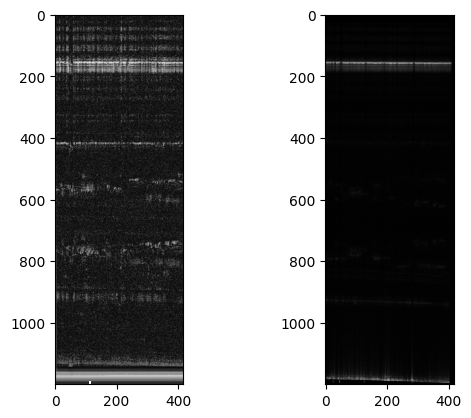

In [828]:
plt.subplot(1,2,1)
plt.imshow(IR_OCDS_mask_tou,cmap='gray')

plt.subplot(1,2,2)
plt.imshow(IR_pics_with_line[500],cmap='gray')

In [89]:
corrs = []
for i in range(2,len(IR_pics_with_line),2):    
    corrs.append(np.corrcoef(np.log10(IR_pics_with_line[0][:,161]+1),np.log10(IR_pics_with_line[i][:,161]+1))[0][1])

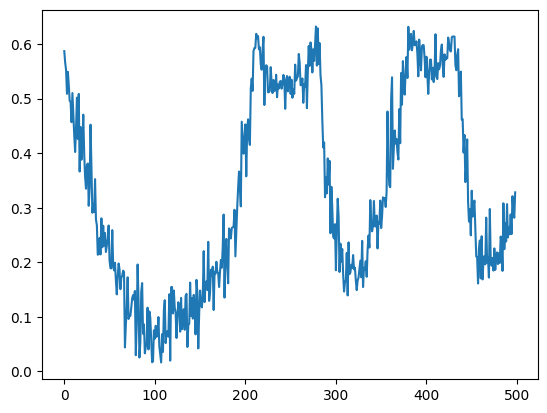

In [90]:
plt.plot(corrs)

In [814]:
slope, intercept = np.polyfit(range(len(corrs)),np.array(corrs),deg=1)

In [815]:
regression_line = slope * range(len(corrs)) + intercept

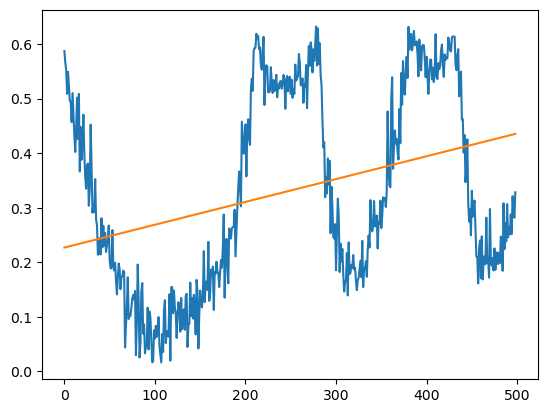

In [816]:
plt.plot(range(len(corrs)),np.array(corrs))
plt.plot(range(len(corrs)),regression_line)

In [817]:
slope

0.00041820672906342916

In [824]:
hsv_image = np.transpose([np.full_like(IR_pics_with_line[0],fill_value=slope), np.ones_like(IR_pics_with_line[0]), IR_pics_with_line[100]], (1, 2, 0))
tmp_img_hsv = cv.cvtColor(hsv_image.astype(np.float32), cv.COLOR_HSV2RGB).astype(np.uint16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


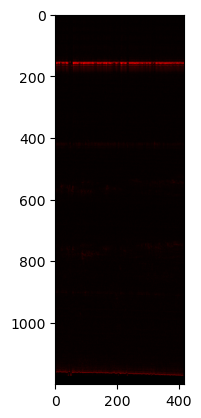

In [825]:
plt.imshow(tmp_img_hsv)

# Other

In [22]:
# path = '/Users/akapatil/Documents/OCT/2D/2D_timelapse_postsolution/scan1/pic/frame1.dcm'

In [206]:
# imggg = image_adjusted_intensity[23].copy()
# imggg_orig = image_adjusted_intensity[0].copy()


imggg = dicom.dcmread('/Users/akapatil/Documents/OCT/2D/2D_timelapse_postsolution/scan1/pic/frame4900.dcm').pixel_array
imggg_orig = dicom.dcmread('/Users/akapatil/Documents/OCT/2D/2D_timelapse_postsolution/scan1/pic/frame650.dcm').pixel_array


In [210]:
point = np.argmax(np.sum(imggg[:500],axis=1))

In [211]:
imggg[point-50:point+50]=0

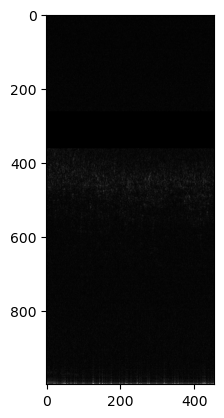

In [212]:
plt.imshow(imggg,cmap='gray')

In [175]:
# aa = image_adjusted_intensity[0]
# bb = image_adjusted_intensity[50]
aa = imggg
bb = imggg_orig
_,binImgaa = cv.threshold(aa, 25, 1,  cv.THRESH_BINARY )
_,binImgbb = cv.threshold(bb, 25, 1,  cv.THRESH_BINARY )

In [176]:
np.mean(bb[300:800])

16.946612334801763

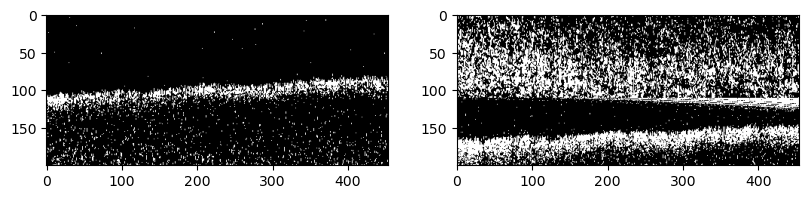

In [182]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(binImgaa[300:500],cmap='gray')

plt.subplot(1,3,2)
plt.imshow(np.roll(binImgbb[300:500],shift=(111),axis=(0)),cmap='gray')


In [178]:
phase_cross_correlation(binImgaa[300:800], binImgbb[300:800])[0][0]

111.0

In [387]:
# Load your two noisy images
image1 = cv.convertScaleAbs(imggg)
image2 = cv.convertScaleAbs(imggg_orig)

point1 = np.argmax(np.sum(image1[:500],axis=1))
point2 = np.argmax(np.sum(image2[:500],axis=1))
main_point = max(point1,point2)
# roi1 = image1[50:50 + roi_height, 50:50 + roi_width]
# roi2 = image2[50:50 + roi_height, 50:50 + roi_width]

correlation = cv2.matchTemplate(image2[600:800], image1[600:800], cv2.TM_CCOEFF_NORMED)
_, _, _, max_loc = cv2.minMaxLoc(correlation)

# Extract the shift
shift_x, shift_y = max_loc
print(shift_x, shift_y)

# Apply the shift to the entire image2
rows, cols = imggg_orig.shape
M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
aligned_image2 = cv2.warpAffine(imggg_orig, M, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)


0 0


In [188]:
blurred = ndimage.uniform_filter(imggg, size=10)

In [189]:
edges = cv2.Canny(cv.convertScaleAbs(blurred), 30, 100)  # Adjust the threshold values as needed

contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask from the first contour
mask = np.zeros_like(imggg)
cv2.drawContours(mask, contours, 0, (255), thickness=cv2.FILLED)

# Remove pixels inside the first contour
result_image = cv2.bitwise_and(imggg, cv2.bitwise_not(mask))

# Draw contours on the image
# cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)  # Draw all contours in green


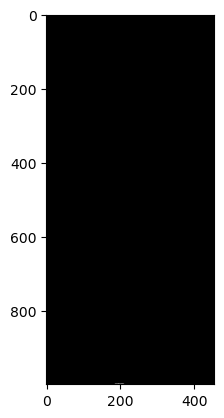

In [192]:
plt.imshow(mask,cmap='gray')

In [170]:
from sklearn.cluster import KMeans
gray_image = blurred

# Flatten the image to create a feature vector for K-means
flat_image = gray_image.flatten().reshape((-1, 1))

# Specify the number of clusters (K)
k = 3

# Apply K-means clustering
kmeans = KMeans(n_clusters=k,algorithm='lloyd')
kmeans.fit(flat_image)

# Get the labels and reshape them to the shape of the original image
segmented_image = kmeans.labels_.reshape(gray_image.shape)

# # Set the values of the pixels in the first cluster to 0
segmented_image = np.where(segmented_image == 1, 0, imggg)


/Users/akapatil/opt/anaconda3/envs/oct_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [171]:
segmented_image

array([[12,  9,  5, ...,  3,  5, 12],
       [ 1,  4,  5, ...,  1,  6, 17],
       [11,  2,  8, ...,  8, 13, 15],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint16)

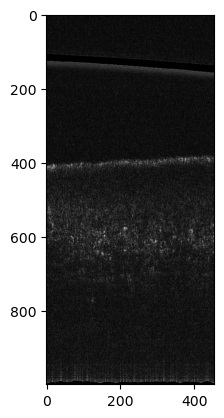

In [172]:
plt.imshow(segmented_image,cmap='gray')

In [40]:
binary_image = cv2.adaptiveThreshold(cv.convertScaleAbs(imggg), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 3)

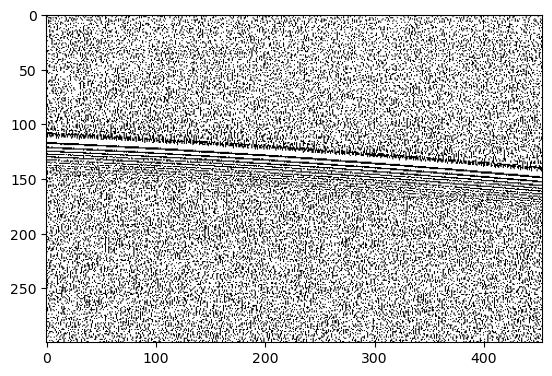

In [41]:
plt.imshow(binary_image[:300],cmap='gray')

In [91]:


warped_image = phase_cross_correlation(imggg[300:800], imggg_orig[300:800])

In [102]:
v, u = optical_flow_tvl1(imggg[300:800], imggg_orig[300:800])

In [113]:
nr, nc = 500,454

row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')

gg = np.array([row_coords + v, col_coords + u])
padded_array = np.pad(gg, ((300, 200), (0, 0)), mode='constant', constant_values=0)


image1_warp = warp(imggg_orig,padded_array ,
                   mode='constant')

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (2,2)  and requested shape (3,2)

In [111]:
padded_array

NameError: name 'padded_array' is not defined

In [88]:
a = np.roll(imggg_orig,shift = (int(warped_image[0][0])),axis = (0))

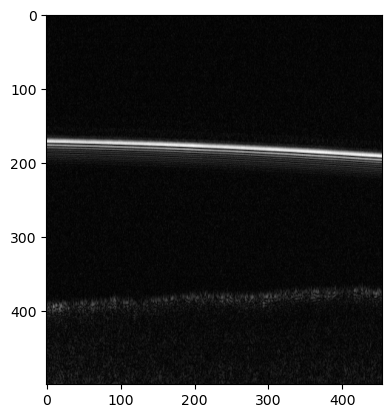

In [109]:
plt.imshow(image1_warp,cmap='gray')

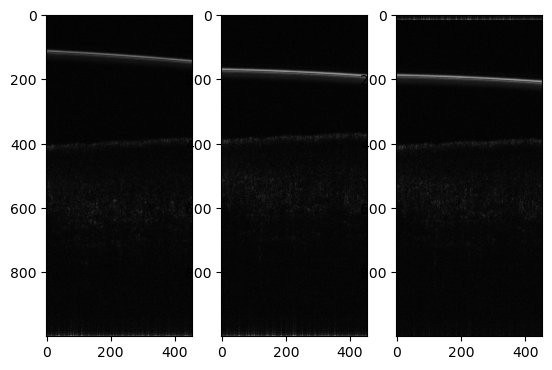

In [90]:
plt.subplot(1,3,1)
plt.imshow(imggg,cmap='gray')

plt.subplot(1,3,2)
plt.imshow(imggg_orig,cmap='gray')

plt.subplot(1,3,3)
plt.imshow(a,cmap='gray')

In [26]:
imggg_orig[300:,17]

array([  7,   9,   4,   5,   4,   3,   5,   5,   5,   5,   5,   5,   9,
         4,   6,  12,  12,   8,   3,   2,   6,   7,   6,  11,  11,   7,
        13,  14,  10,  12,   9,   7,   7,   9,   8,   6,  10,   2,  10,
        13,  11,   3,  11,  13,   4,   8,   8,   7,   9,  10,  10,   7,
         2,   3,  10,  10,   3,  13,  11,   3,  11,  13,  10,  12,  11,
         2,   9,   6,   3,   7,   6,   3,   5,   8,   8,   4,   3,   7,
        10,   4,  12,   9,   7,  16,  13,  13,  13,  11,  22,  34,  35,
        30,  33,  36,  22,  21,  70, 112, 125, 100,  72,  78,  82,  64,
        30,  54,  60,  26,  30,  30,   6,  31,  34,  15,  26,  29,  36,
        41,  25,  27,  26,  12,   5,  10,  10,   4,  13,  11,  10,   9,
        20,  25,  18,  21,  35,  40,  34,  23,  14,   3,  18,  19,   4,
        15,  22,  20,  19,  18,  15,  15,  20,  21,  12,   5,  11,  24,
        30,  31,  34,  22,  18,  33,  31,  20,  16,  21,  25,  23,  14,
         8,  11,  17,  22,  24,  31,  35,  35,  34,  33,  28,  1

In [25]:
imggg[300:,17]

array([  3,   3,   4,   4,   6,   4,   5,   9,   3,   6,  12,  12,  10,
        10,  13,  13,  12,  16,  17,  13,  11,  14,  15,  14,  12,  12,
        10,   4,   9,  14,  11,  10,   9,   9,  14,   8,   3,   7,   5,
         4,   2,   8,   8,   4,  10,  13,  11,   9,   9,  10,   9,   4,
         4,   8,   6,  10,  11,   2,  10,  13,  12,  12,   8,   8,  11,
        13,  13,   8,   7,  10,   5,   3,   4,   3,   4,  12,  17,  12,
         7,  12,  12,   9,   8,  10,  11,   8,   5,   9,   6,   2,   5,
         6,   5,   5,  12,  12,   5,   1,   2,   9,  13,   8,  12,  22,
        22,  23,  32,  40,  33,  13,  30,  61,  86,  91,  77,  68,  75,
        81,  72,  51,  44,  40,  25,  22,  25,  20,   3,  18,  25,  16,
        10,  12,   7,   8,   5,  20,  21,  10,  12,  10,  14,  11,   7,
        10,  11,  15,  24,  22,  17,  23,  16,  14,  22,  17,  14,  13,
         9,   9,  13,  13,  14,  18,  20,  10,   9,  21,  20,  21,  18,
         5,  11,  21,  21,  17,  11,   3,   9,  15,  17,  22,  2

In [295]:
flat_image(imggg)
flat_image(imggg_orig)
trans = match_image(imggg,imggg_orig)

In [296]:
trans

array([[18, 18, 15, ...,  9,  9,  9],
       [17, 18, 14, ..., 10, 10,  9],
       [17, 18, 15, ..., 10, 10,  9],
       ...,
       [ 6,  8, 10, ..., 14, 12, 10],
       [ 7, 10, 12, ..., 16, 13, 11],
       [ 8, 12, 16, ..., 17, 14, 11]], dtype=uint16)

In [285]:
highlight = np.argmax(np.sum(imggg[:500],axis=1))
tp_img = imggg[highlight-100:highlight+100].copy()
tp_img = cv.convertScaleAbs(tp_img)

In [224]:
_,binary_image = cv.threshold(tp_img, 240, 255,  cv.THRESH_BINARY)
    
for i in range(binary_image.shape[1]):
    if len(np.where(binary_image[:,i]==255)[0])!=0:
        start = min(np.where(binary_image[:,i]==255)[0])

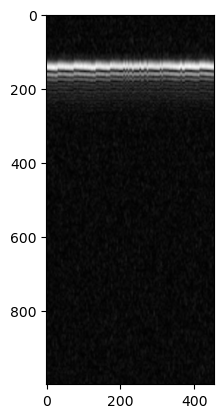

In [297]:
plt.imshow(trans,cmap='gray')

In [226]:
for i in range(binary_image.shape[1]):
    column_to_shift = i
    try:
        shift_amount = -(start - min(np.where(binary_image[:, i] == 255)[0]))
    except:
        shift_amount = 0
    num_rows = imggg.shape[0]
    new_column_index = np.arange(num_rows) + shift_amount
    new_column_index[new_column_index < 0] = 0
    new_column_index[new_column_index >= num_rows] = 0
    imggg[:, column_to_shift] = imggg[new_column_index.astype(int), column_to_shift]

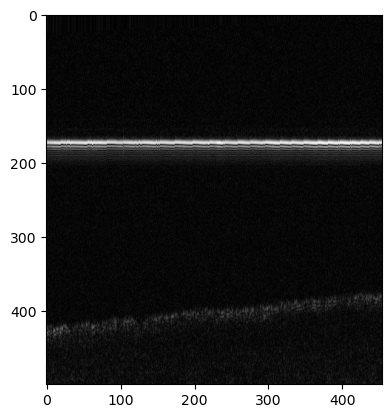

In [228]:
plt.imshow(imggg[:500],cmap='gray')

In [55]:
my_g = dicom.dcmread('/Users/akapatil/Documents/OCT/2D/2D_timelapse_postsolution/scan1/pic/frame4500.dcm').pixel_array

In [53]:
my_g[200,:] =650

In [52]:
np.max(my_g)

661

In [56]:
my_g[np.argmax(np.sum(my_g,axis=1)),:]=650

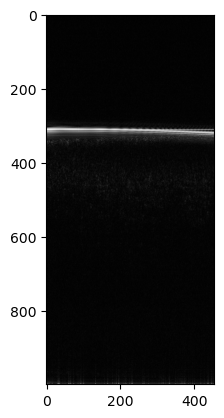

In [57]:
plt.imshow(my_g,cmap='gray')

In [1487]:
path = 'Oct_10_2023_IR_card_motion/scan 3/pic/'
# os.mkdir(path+'only_intensity')

In [1499]:

file_list = os.listdir(path)

# Sort the list of files using natural sorting
sorted_file_list = natsorted(file_list)

# Now, sorted_file_list contains the paths sorted in a natural order
print(sorted_file_list)

['.DS_Store', 'Flat', 'flat_transformed_new', 'frame1.dcm', 'frame2.dcm', 'frame3.dcm', 'frame4.dcm', 'frame5.dcm', 'frame6.dcm', 'frame7.dcm', 'frame8.dcm', 'frame9.dcm', 'frame10.dcm', 'frame11.dcm', 'frame12.dcm', 'frame13.dcm', 'frame14.dcm', 'frame15.dcm', 'frame16.dcm', 'frame17.dcm', 'frame18.dcm', 'frame19.dcm', 'frame20.dcm', 'frame21.dcm', 'frame22.dcm', 'frame23.dcm', 'frame24.dcm', 'frame25.dcm', 'frame26.dcm', 'frame27.dcm', 'frame28.dcm', 'frame29.dcm', 'frame30.dcm', 'frame31.dcm', 'frame32.dcm', 'frame33.dcm', 'frame34.dcm', 'frame35.dcm', 'frame36.dcm', 'frame37.dcm', 'frame38.dcm', 'frame39.dcm', 'frame40.dcm', 'frame41.dcm', 'frame42.dcm', 'frame43.dcm', 'frame44.dcm', 'frame45.dcm', 'frame46.dcm', 'frame47.dcm', 'frame48.dcm', 'frame49.dcm', 'frame50.dcm', 'frame51.dcm', 'frame52.dcm', 'frame53.dcm', 'frame54.dcm', 'frame55.dcm', 'frame56.dcm', 'frame57.dcm', 'frame58.dcm', 'frame59.dcm', 'frame60.dcm', 'frame61.dcm', 'frame62.dcm', 'frame63.dcm', 'frame64.dcm', 'fr

In [1504]:

    
    # for i,j in enumerate(intensity_img):
    #     cv.imwrite(path + 'only_intensity/' + f'frame{i+1}' + '.PNG', j)

dtype('uint16')

In [1508]:
# for j in range(oo.shape[1]):
#     for g in all_imgs:
#         if g[np.argmax(g[:500,j]),j]!=0:
#             val = mean_args[j]/(g[np.argmax(g[:500,j]),j])
#             if val!=0:
#                 g[:,j] = g[:,j] * val
#         # args.append(g[np.argmax(g[:500,j]),j])

In [1462]:
def match_image(img1,img2):
    image1 = cv.convertScaleAbs(img1[:500])
    image2 = cv.convertScaleAbs(img2[:500])
    # image1 = img1
    # image2 = img2
    orb = cv.ORB_create()
    # print(img1.dtype)
    kp1, des1 = orb.detectAndCompute(image1, None)
    kp2, des2 = orb.detectAndCompute(image2, None)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M, _ = cv.estimateAffinePartial2D(src_pts, dst_pts)
    M_inv = cv.invertAffineTransform(M)
    aligned_image2 = cv.warpAffine(img2, M_inv, (img1.shape[1], img1.shape[0]))
    # print(aligned_image2.dtype)

    return aligned_image2

def parse_image(pic1,pic2,filename,path):
    # ds1 = dicom.dcmread(pic1)
    # ds2 = dicom.dcmread(pic2,force=True)
    # pic1_flat_array = flat_image(ds1.pixel_array)
    # pic2_flat_array = flat_image(ds2.pixel_array)
    pic1_flat_array = cv.imread(pic1,cv.IMREAD_UNCHANGED)
    pic2_flat_array = cv.imread(pic2,cv.IMREAD_UNCHANGED)
    transformed_image = match_image(pic1_flat_array,pic2_flat_array)
    cv.imwrite(path + 'tranformed_intensity/' + f'{filename}' + '.PNG', transformed_image)


def flat_image(imggg):
    # highlight = np.argmax(np.sum(imggg[:500],axis=1))
    # tp_img = imggg[highlight-100:highlight+100].copy()
    tp_img = cv.convertScaleAbs(imggg[:500])

    if np.max(imggg)>700:
        _, binary_image = cv.threshold(tp_img, 200, 255,  cv.THRESH_BINARY )
    else:
        _, binary_image = cv.threshold(tp_img, 200, 255,  cv.THRESH_OTSU )
        
    for i in range(binary_image.shape[1]):
        if len(np.where(binary_image[:,i]==255)[0])!=0:
            start = min(np.where(binary_image[:,i]==255)[0])

    for i in range(binary_image.shape[1]):
        column_to_shift = i
        try:
            shift_amount = -(start - min(np.where(binary_image[:, i] == 255)[0]))
        except:
            shift_amount = 0
        num_rows = imggg.shape[0]
        new_column_index = np.arange(num_rows) + shift_amount
        new_column_index[new_column_index < 0] = 0
        new_column_index[new_column_index >= num_rows] = 0
        imggg[:, column_to_shift] = imggg[new_column_index.astype(int), column_to_shift]
    return imggg

In [1463]:
path = 'Oct_10_2023_IR_card_motion/scan 3/pic/flat_transformed_new/intensity/'

reference_img = 'Oct_10_2023_IR_card_motion/scan 3/pic/flat_transformed_new/intensity/frame1.PNG'
os.mkdir(path+'tranformed_intensity')
for i in os.listdir(path):
    if i.endswith('.PNG'):
        filename = i.removesuffix('.PNG')
        pic1 = reference_img
        pic2 = path+i
        try:
            parse_image(pic1,pic2,filename,path)
        except:
            print(i)

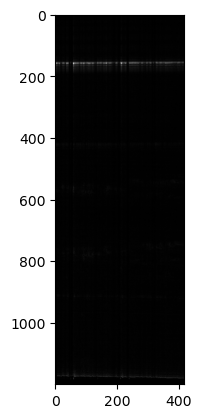

In [1208]:
plt.imshow(all_imgs[200],cmap='gray')

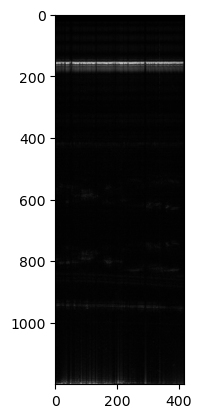

In [1204]:
oo509  = cv.imread(path+'frame509.PNG',cv.IMREAD_UNCHANGED)
plt.imshow(oo509,cmap='gray')

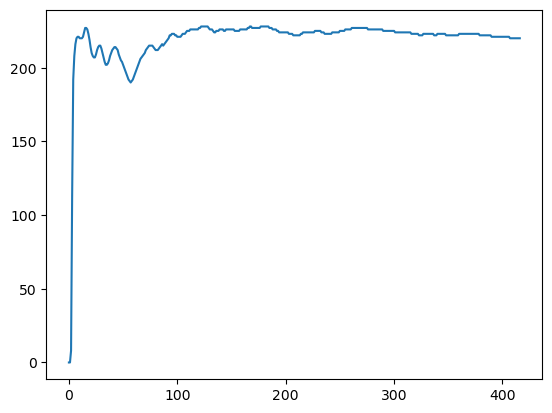

In [1184]:
plt.plot(mean_args)

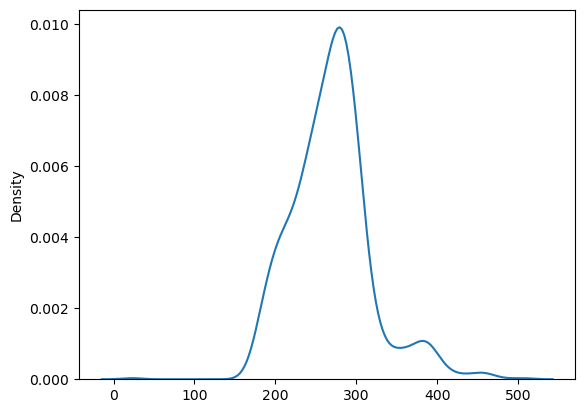

In [1157]:

from numpy import array, linspace
from sklearn.neighbors import KernelDensity
import seaborn as sns

# kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(np.array(args).reshape(-1,1))
# s = linspace(0,1000)
# e = kde.score_samples(s.reshape(-1,1))
frames = [i for i in range(1,1001)]
sns.kdeplot(args)

# plt.hist(args, bins=range(min(args), max(args) + 1), edgecolor='black', alpha=0.7)
plt.show()

827


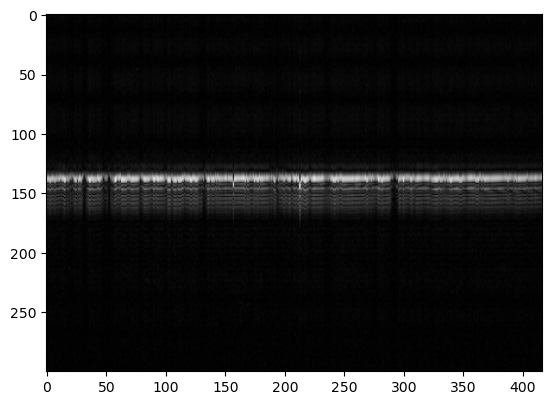

In [1080]:
igg2 = dicom.dcmread('Oct_10_2023_IR_card_motion/scan 3/pic/frame470.dcm').pixel_array
import cv2
import numpy as np
imggg=igg2
print(np.max(igg2))
# highlight = np.argmax(np.sum(imggg[:500],axis=1))
# tp_img = imggg[highlight-50:highlight+50].copy()
tp_img = cv.convertScaleAbs(imggg[:500])
# if np.max(imggg)>700:
_, binary_image = cv.threshold(tp_img, 100, 255,  cv.THRESH_BINARY | cv.THRESH_OTSU)
# else:
#     _, binary_image = cv.threshold(tp_img, 200, 255,  cv.THRESH_OTSU )
for i in range(binary_image.shape[1]):
    if len(np.where(binary_image[:,i]==255)[0])!=0:
        start = min(np.where(binary_image[:,i]==255)[0])
# start = min(np.where(aligned_image[:,0]==255)[0])
for i in range(binary_image.shape[1]):
    column_to_shift = i
    try:
        shift_amount = -(start - min(np.where(binary_image[:, i] == 255)[0]))
    except:
        shift_amount = 0
    num_rows = imggg.shape[0]
    new_column_index = np.arange(num_rows) + shift_amount
    new_column_index[new_column_index < 0] = 0
    new_column_index[new_column_index >= num_rows] = 0
    imggg[:, column_to_shift] = imggg[new_column_index.astype(int), column_to_shift]

plt.imshow(igg2[:300],cmap='gray')

In [1021]:
binary_image[:300]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [977]:
oo = cv.convertScaleAbs(igg2)
_, binary_image = cv.threshold(oo, 250, 255,  cv.THRESH_BINARY + cv.THRESH_OTSU)
contours, _ = cv.findContours(binary_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)


aligned_image = np.zeros_like(oo)
cv.drawContours(aligned_image, contours, -1, (255, 255, 255),0)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0, 255,   0],
       [  0,   0,   0, ...,   0, 255,   0],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

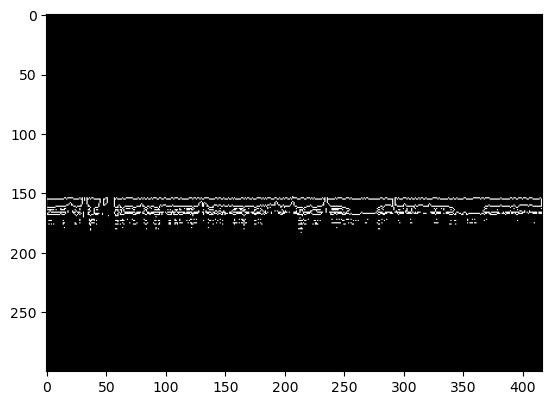

In [978]:

plt.imshow(aligned_image[:300],cmap='gray')

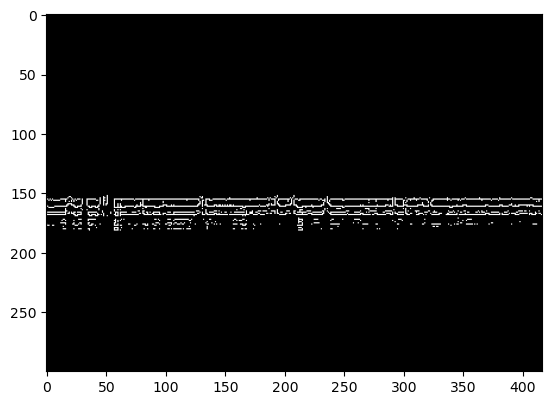

In [938]:
# igg2 = dicom.dcmread('Oct_10_2023_IR_card_motion/scan 3/pic/frame1.dcm').pixel_array
igg2 = cv.convertScaleAbs(imggg[:300])
oo = cv.Canny(igg2,250,255)
plt.imshow(oo[:300],cmap='gray')

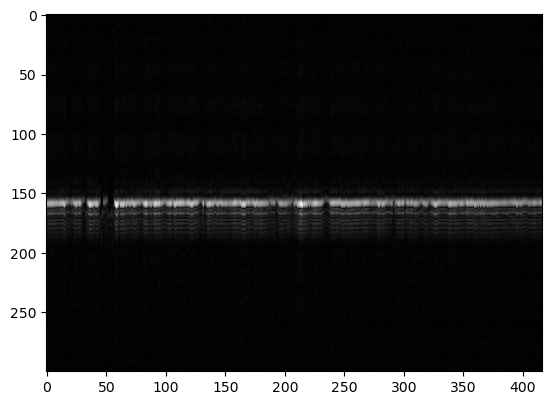

In [980]:
plt.imshow(igg2[:300],cmap='gray')

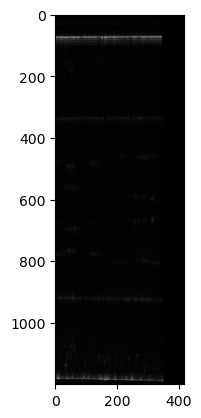

In [535]:
plt.imshow(g1,cmap='gray')

In [531]:
# g1[np.argmax(np.sum(g1[:300],axis=1))]=600

In [532]:
# edges = cv.Canny(cv.convertScaleAbs(g1),255,255)

In [678]:
def plot_lines(path,num):
    image1 = path
    g1 = cv.imread(image1,cv.IMREAD_UNCHANGED)
    intensity_arr = np.zeros_like(g1).astype(float)
    for i in range(g1.shape[1]):
        column_max = np.argmax(g1[:150,i])
        if column_max!=0:
            intensity_arr[:,i] = (g1[:,i]/g1[column_max,i])
        # else:
        #     intensity_arr[:,i] = g1[:,i]
    mean_arr=[]
    for i in range(intensity_arr.shape[1]):
        mean_arr.append(np.median(intensity_arr[850:1000,i]))
    plt.plot(mean_arr,label=num)
    plt.legend()
    

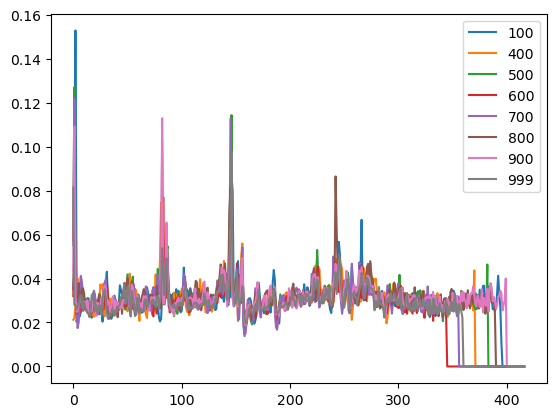

In [679]:
nums = [100,400,500,600,700,800,900,999]
for num in nums:
    plot_lines(f'Oct_10_2023_IR_card_motion/scan 4/pic/flat_transformed_new/frame{num}.PNG',num)

In [675]:
def plot_lines(path,num):
    # image2 = 'Oct_10_2023_IR_card_motion/scan 3/pic/frame671.dcm'
    image2 = path
    g2 = cv.imread(image2,cv.IMREAD_UNCHANGED)
    # g2 = cv.imread(image2,cv.IMREAD_UNCHANGED)
    intensity_arr = np.zeros_like(g2).astype(float)
    for i in range(g2.shape[1]):
        column_max = np.argmax(g2[:300,i])
        if column_max!=0:
            intensity_arr[:,i] = (g2[:,i]/g2[column_max,i])
        # else:
        #     intensity_arr[:,i] = g2[:,i]

    mean_arr=[]
    for i in range(intensity_arr.shape[1]):
        mean_arr.append(np.median(intensity_arr[850:1000,i]))
    plt.plot(mean_arr,label=num)
    plt.legend()
    

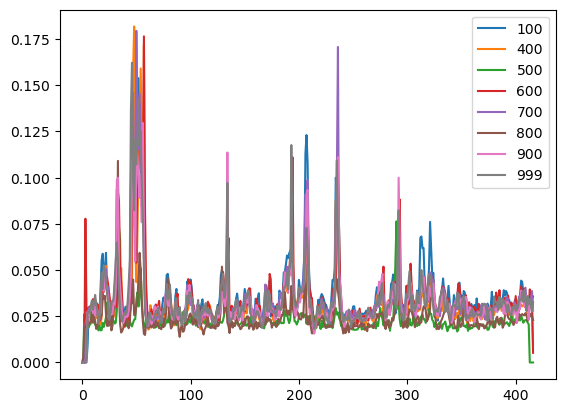

In [676]:
nums = [100,400,500,600,700,800,900,999]
for num in nums:
    plot_lines(f'Oct_10_2023_IR_card_motion/scan 3/pic/flat_transformed_new/frame{num}.PNG',num)

In [722]:
np.argmax(np.sum(igg1[:300],axis=1))

158

In [718]:
np.argmax(igg1[:300])

66515

In [ ]:
inte = []
for i in range(1,1001):
    igg1 = cv.imread(f'Oct_10_2023_IR_card_motion/scan 3/pic/flat_transformed_new/frame{i}.PNG')
    inte

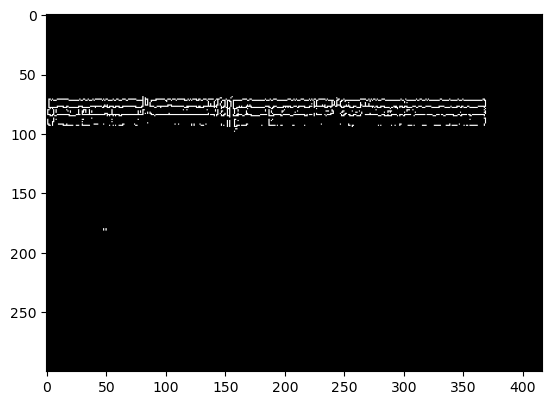

In [286]:
# plt.subplot(121),plt.imshow(g1[:300],cmap = 'gray')
plt.imshow(edges[:300],cmap = 'gray')

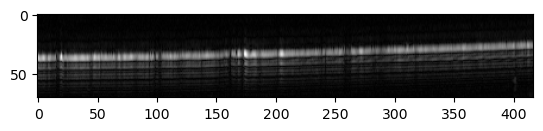

In [22]:
imggg = ds1.pixel_array
plt.imshow(imggg[50:120],cmap='gray')
tp_img = imggg[50:120].copy()

In [328]:
scan3_down = ds_scan3[200:500].copy()
scan3_up = ds_scan3[0:300].copy()
# scan3_up[np.argmax((np.sum(scan3_up,axis=1)))]=400
# g[np.argmax((np.sum(g,axis=1)))+50]=60

In [329]:
np.nanmean(np.divide(scan3_up[np.argmax((np.sum(scan3_up,axis=1)))],scan3_down[np.argmax((np.sum(scan3_down,axis=1)))]))

13.289083810547423

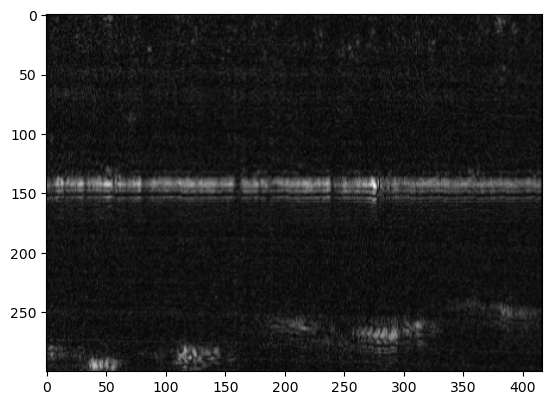

In [333]:
plt.imshow(scan4_down,cmap='gray')

In [330]:
scan4_down = ds_scan4[200:500].copy()
scan4_up = ds_scan4[0:300].copy()

In [331]:
g = np.divide(scan4_up[np.argmax((np.sum(scan4_up,axis=1)))],scan4_down[np.argmax((np.sum(scan4_down,axis=1)))])
for i in range(len(g)):
    if g[i]==np.inf:
        g[i]=np.nan



/var/folders/y0/g6cs3y9d4hlc0g10qn8s1bdc0000gn/T/ipykernel_21256/3039638979.py:1: RuntimeWarning: invalid value encountered in divide
  g = np.divide(scan4_up[np.argmax((np.sum(scan4_up,axis=1)))],scan4_down[np.argmax((np.sum(scan4_down,axis=1)))])
